In [1]:
%%capture

!pip install transformers diffusers accelerate -U
!pip install parediffusers

!pip install torchview graphviz

In [2]:
from PIL import Image
from IPython.display import Image as IPythonImage
import imageio
from tqdm import tqdm
import os
import matplotlib.pyplot as plt
import torch
from diffusers.utils.export_utils import export_to_gif
from parediffusers import PareDiffusionPipeline

# Prepare for saving as .gif
def make_gif_with_index(images, file_path, figsize=(1.28, 1.30)):
	for i, image in enumerate(images):
		fig, ax = plt.subplots(figsize=figsize)
		ax.imshow(image)
		ax.text(0.5, -0.2, f"Index: {i}", transform=ax.transAxes, ha="center")
		ax.axis('off')
		plt.subplots_adjust(bottom=0.2)
		plt.savefig(f"temp_{i}.png")
		plt.close(fig)

	# Read temporary images and append to the list
	images_with_index = []
	for i in range(len(images)):
		images_with_index.append(Image.open(f"temp_{i}.png"))

	# Save as .gif
	export_to_gif(images_with_index, file_path, fps=10)

	# Remove temporary image files
	for i in range(len(images)):
		os.remove(f"temp_{i}.png")

/usr/local/lib/python3.9/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


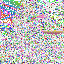

In [3]:
pre_last_latent = None

@torch.no_grad()
def denoise(self, latents, prompt_embeds, num_inference_steps=50, guidance_scale=7.5):
	"""
	Iteratively denoise the latent space using the diffusion model to produce an image.
	"""
	global pre_last_latent

	timesteps, num_inference_steps = self.retrieve_timesteps(num_inference_steps)

	for t in timesteps:
		latent_model_input = torch.cat([latents] * 2)
		
		# Predict the noise residual for the current timestep
		noise_residual = self.unet(latent_model_input, t, encoder_hidden_states=prompt_embeds)
		uncond_residual, text_cond_residual = noise_residual.chunk(2)
		
		guided_noise_residual = uncond_residual + guidance_scale * (text_cond_residual - uncond_residual)

		# Update latents by reversing the diffusion process for the current timestep
		latents = self.scheduler.step(guided_noise_residual, t, latents)[0]
		
		if t == timesteps[-2]:
			pre_last_latent = latents

	return latents

PareDiffusionPipeline.denoise = denoise

pipe = PareDiffusionPipeline.from_pretrained(
	"stabilityai/stable-diffusion-2",
	device=torch.device("cuda"),
	dtype=torch.float16,
)
prompt = "painting depicting the sea, sunrise, ship, artstation, 4k, concept art"

torch.manual_seed(42)
image = pipe(prompt, width=512, height=512, num_inference_steps=100)

display(pipe.tensor_to_image(pre_last_latent[0]))

In [4]:
import torch
from torch import nn
from typing import List, Union
import json
from huggingface_hub import hf_hub_download
from parediffusers.utils import DotDict, get_activation
from parediffusers.defaults import DEFAULT_UNET_CONFIG
from parediffusers.models.embeddings import PareTimestepEmbedding, PareTimesteps
from parediffusers.models.unet_2d_get_blocks import pare_get_down_block, pare_get_up_block
from parediffusers.models.unet_2d_mid_blocks import PareUNetMidBlock2DCrossAttn

from parediffusers import PareUNet2DConditionModel

samples = []

def forward(
	self,
	sample: torch.FloatTensor,
	timestep: Union[torch.Tensor, float, int],
	encoder_hidden_states: torch.Tensor,
) -> torch.FloatTensor:
	forward_upsample_size = False
	upsample_size = None

	# 1. time
	timesteps = timestep
	if len(timesteps.shape) == 0:
		timesteps = timesteps[None].to(sample.device)

	# broadcast to batch dimension in a way that's compatible with ONNX/Core ML
	timesteps = timesteps.expand(sample.shape[0])

	t_emb = self.time_proj(timesteps)
	t_emb = t_emb.to(dtype=pipe.dtype)

	emb = self.time_embedding(t_emb, None)
	aug_emb = None

	emb = emb + aug_emb if aug_emb is not None else emb

	# 2. pre-process
	samples.append(('init', sample))
	sample = self.conv_in(sample)
	samples.append(('conv_in', sample))

	# 3. down
	down_block_res_samples = (sample,)
	for i, downsample_block in enumerate(self.down_blocks):
		if hasattr(downsample_block, "has_cross_attention") and downsample_block.has_cross_attention:
			# For t2i-adapter CrossAttnDownBlock2D
			additional_residuals = {}
			sample, res_samples = downsample_block(
				hidden_states=sample,
				temb=emb,
				encoder_hidden_states=encoder_hidden_states,
				**additional_residuals,
			)
		else:
			sample, res_samples = downsample_block(hidden_states=sample, temb=emb)
		down_block_res_samples += res_samples
		
		samples.append((f"down_blocks_{i}", sample))

	# 4. mid
	if self.mid_block is not None:
		if hasattr(self.mid_block, "has_cross_attention") and self.mid_block.has_cross_attention:
			sample = self.mid_block(
				sample,
				emb,
				encoder_hidden_states=encoder_hidden_states,
			)
		else:
			sample = self.mid_block(sample, emb)
		
		samples.append((f"mid_block", sample))

	# 5. up
	for i, upsample_block in enumerate(self.up_blocks):
		is_final_block = i == len(self.up_blocks) - 1

		res_samples = down_block_res_samples[-len(upsample_block.resnets) :]
		down_block_res_samples = down_block_res_samples[: -len(upsample_block.resnets)]

		if not is_final_block and forward_upsample_size:
			upsample_size = down_block_res_samples[-1].shape[2:]

		if hasattr(upsample_block, "has_cross_attention") and upsample_block.has_cross_attention:
			sample = upsample_block(
				hidden_states=sample,
				temb=emb,
				res_hidden_states_tuple=res_samples,
				encoder_hidden_states=encoder_hidden_states,
				upsample_size=upsample_size,
			)
		else:
			sample = upsample_block(
				hidden_states=sample,
				temb=emb,
				res_hidden_states_tuple=res_samples,
				upsample_size=upsample_size,
			)
		
		samples.append((f"up_blocks{i}", sample))

	# 6. post-process
	if self.conv_norm_out:
		sample = self.conv_norm_out(sample)
		sample = self.conv_act(sample)
	sample = self.conv_out(sample)
	samples.append(('conv_out', sample))

	return sample

PareUNet2DConditionModel.forward = forward

pipe.unet = PareUNet2DConditionModel.from_pretrained(
	"stabilityai/stable-diffusion-2",
	device=pipe.device,
	dtype=pipe.dtype,
).to(device=pipe.device, dtype=pipe.dtype)


In [5]:
timesteps, num_inference_steps = pipe.retrieve_timesteps(50)
prompt = "painting depicting the sea, sunrise, ship, artstation, 4k, concept art"
prompt_embeds = pipe.encode_prompt(prompt).to(pipe.device)
t = timesteps[-1].to(pipe.device)
latents = pre_last_latent.to(pipe.device)

latent_model_input = torch.cat([latents] * 2).to(pipe.device)

# Predict the noise residual for the current timestep
noise_residual = pipe.unet(latent_model_input, t, encoder_hidden_states=prompt_embeds)
uncond_residual, text_cond_residual = noise_residual.chunk(2)
guided_noise_residual = uncond_residual + 7.5 * (text_cond_residual - uncond_residual)

# Update latents by reversing the diffusion process for the current timestep
latents = pipe.scheduler.step(guided_noise_residual, t, latents)[0]

In [6]:
len(samples)

12

In [7]:
for key, value in samples:
	print(key.ljust(16), value.shape)

init             torch.Size([2, 4, 64, 64])
conv_in          torch.Size([2, 320, 64, 64])
down_blocks_0    torch.Size([2, 320, 32, 32])
down_blocks_1    torch.Size([2, 640, 16, 16])
down_blocks_2    torch.Size([2, 1280, 8, 8])
down_blocks_3    torch.Size([2, 1280, 8, 8])
mid_block        torch.Size([2, 1280, 8, 8])
up_blocks0       torch.Size([2, 1280, 16, 16])
up_blocks1       torch.Size([2, 1280, 32, 32])
up_blocks2       torch.Size([2, 640, 64, 64])
up_blocks3       torch.Size([2, 320, 64, 64])
conv_out         torch.Size([2, 4, 64, 64])
